In [1]:
%load_ext autoreload
%autoreload 1

import numpy as np
import pickle

from gpu import set_gpu
from matplotlib import pyplot as plt
%aimport loop
%aimport session
%aimport plot_utils 
set_gpu()

plt.rcParams['figure.dpi'] = 300
%matplotlib qt

Num GPUs Available:  1


In [2]:
sub_type = 'AB'
with open('train_data_raw_'  + sub_type + '.p', 'rb') as f:
    raw, params,feat,feat_sq = pickle.load(f)

In [ ]:
# Loop through training
all_acc = np.full([np.max(params[:,0]),10,4,6],np.nan)
all_val = np.full([np.max(params[:,0]),10,4,6],np.nan)
i = 0
train_dict = {'sub_type':sub_type,'n_train':'fullgaussflat4', 'load':False, 'train_scale':5, 'epochs': 30, 'batch_size' : 128, 'sparsity':True,'dt':'cv','feat_type':'feat','noise':True, 'latent_dim':4,'mod':['svae'],'gens':50, 'mod_dt':'1012','train_grp':2}
train_sess = session.Session(**train_dict)

# loop through subjects
for sub_i in range(1,2):#np.max(params[:,0])+1):
    for lat in range(1,5):
        train_sess.latent_dim = lat
        train_out = train_sess.loop_cv(raw,params,sub=sub_i,mod='all')
        for key,val in train_out.items():
            exec(key + '=val')


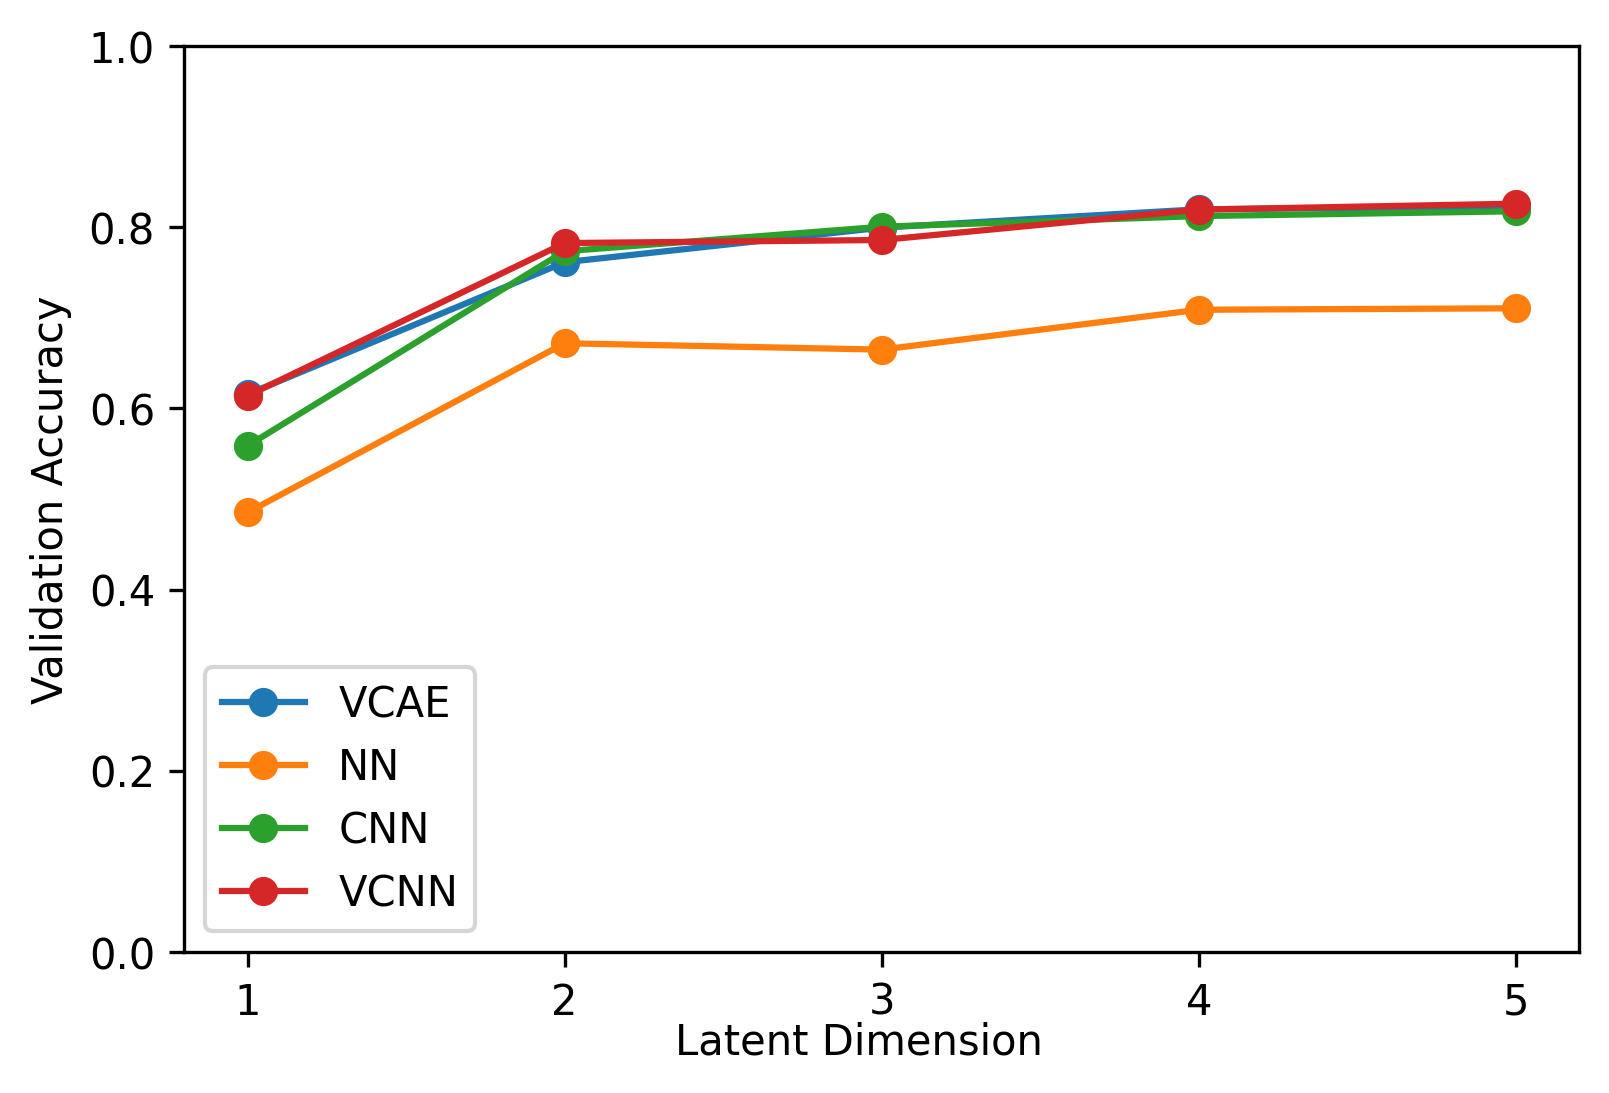

In [24]:
all_acc, all_val = plot_utils.plot_latent_dim(params,train_sess)

In [7]:
# reduce dimensions of inputs
sub = 1
train_sess.latent_dim = 4
train_sess.epochs = 50
red_out = train_sess.reduce_latent(raw, params, sub, cv=1)
for key,val in red_out.items():
    exec(key + '=val')

In [8]:
# plot reduced dimensions in 3D
%matplotlib qt

fig = plt.figure()
plt.tight_layout
col = ['k','b','r','g','c','y','m']
ax = plt.subplot(1,2,1,projection='3d')
ax1 = plt.subplot(1,2,2,projection='3d')
# Loop through classes
for cl in np.unique(y_train_lda):
    ind = np.squeeze(y_valid_noise) == cl
    ind_noise = np.squeeze(y_valid_noise) == cl
    ax.plot3D(x_valid_noise_red[ind,0], x_valid_noise_red[ind,1], x_valid_noise_red[ind,2],'.', c=col[cl])
    ax1.plot3D(x_valid_cnn_red[ind_noise,0], x_valid_cnn_red[ind_noise,1], x_valid_cnn_red[ind_noise,2],'.', c=col[cl])


In [31]:
# Plot generated or reconstructed features
col = ['k','b','r','g','c','y','m']
fig = plt.figure()

# number of channels
ch_max = x_noise.shape[1]

# number of classes
cl_max = y_train.shape[1]

# loop through channels
for i in range(0,ch_max-1):
    ax = plt.subplot(6,1,i+1)

    # loop through classes
    for cl in range(2,3):
        # index inputs from current class
        x_noise_cl = x_noise[y_train[:,cl]==1,i,:]
        x_clean_cl = x_clean[y_train[:,cl]==1,i,:]
        dec_ind = gen_clf == cl

        ## plot all noisy features
        # for x_all in range(0,x_noise_cl.shape[0]):
        #     ax.plot(x_noise_cl[x_all,:,0],col[cl],linewidth=1)

        ## plot all clean features
        for x_all in range(0,x_clean_cl.shape[0]):
            ax.plot(x_clean_cl[x_all,:,0],col[cl],linewidth=.5,linestyle='-')

        ## plot all decoder output
        max_gen = 100
        ax.plot(np.transpose(dec_out[dec_ind,i,:,0][:max_gen,:]),col[cl+1],linewidth=.5,linestyle='--')
        
        ## plot mean of noisy features
        # ax.plot(np.mean(x_cl[:x_cl.shape[0],:,0],axis=0),col[cl],linewidth=1)

        ## plot mean of clean features
        # ax.plot(np.mean(x_clean_cl[:x_clean_cl.shape[0],:,0],axis=0),col[cl],linewidth=1,linestyle=':')

        ## plot mean of reconstructed output
        # rec_cl = dec_out[y_train[:,cl]==1,i,:]
        # ax.plot(np.mean(rec_cl[:,:,0],axis=0),col[cl],linewidth=1,linestyle='--')
        
        ## plot mean of decoder output
        # ax.plot(np.mean(np.transpose(dec_out[dec_ind,i,:,0]),axis=1),col[cl+1],linewidth=.5,linestyle='--')

    ax.set_ylim([0,1])

NameError: name 'x_noise' is not defined

<Figure size 1800x1200 with 0 Axes>

In [31]:
test_dict = {'sub_type':sub_type,'dt':'manual', 'mod_dt':'1012','sparsity':True, 'load':True, 'batch_size':128, 'latent_dim':5, 'epochs':30,'train_scale':5, 'n_train':'fullgaussflat4', 'n_test':'partgauss4','feat_type':'feat', 'noise':True,'train_grp':1}
test_sess = session.Session(**test_dict)

acc_all = np.full([np.max(params[:,0])+1, 3, 4, 15],np.nan)
acc_clean = np.full([np.max(params[:,0])+1, 3, 4, 15],np.nan)
acc_noise = np.full([np.max(params[:,0])+1, 3, 4, 15],np.nan)

for i in range(3,6):
    test_sess.n_test = 'partpos' + str(i)
    # test_out = test_sess.loop_test(raw, params)
    # for key,val in test_out.items():
    #     exec(key + '=val')

    foldername = test_sess.create_foldername()
    filename = test_sess.create_filename(foldername,results=True)
    with open(filename + '_results.p', 'rb') as f:
        temp_all, temp_clean, temp_noise = pickle.load(f)
    acc_all[:,i-3,:,:], acc_clean[:,i-3,:,:], acc_noise[:,i-3,:,:] = np.squeeze(temp_all),np.squeeze(temp_clean),np.squeeze(temp_noise)
# test_dict = {'dt':'cv', 'sparsity':True, 'load':True, 'batch_size':128, 'latent_dim':4, 'epochs':50,'train_scale':5, 'n_train':'fullgaussflat4', 'n_test':'partgauss2','feat_type':'feat', 'noise':True}
# acc_all, acc_noise, acc_clean, file_name = loop.loop_test(raw, params, sub_type,**test_dict)
# acc_noise = np.delete(acc_noise,4,0)
ave_noise= np.nanmean(acc_noise,axis=0)
ave_clean = np.nanmean(acc_clean,axis=0)
gauss_noise = np.nanmean(ave_noise,axis=1)
gauss_clean = np.nanmean(ave_clean,axis=1)

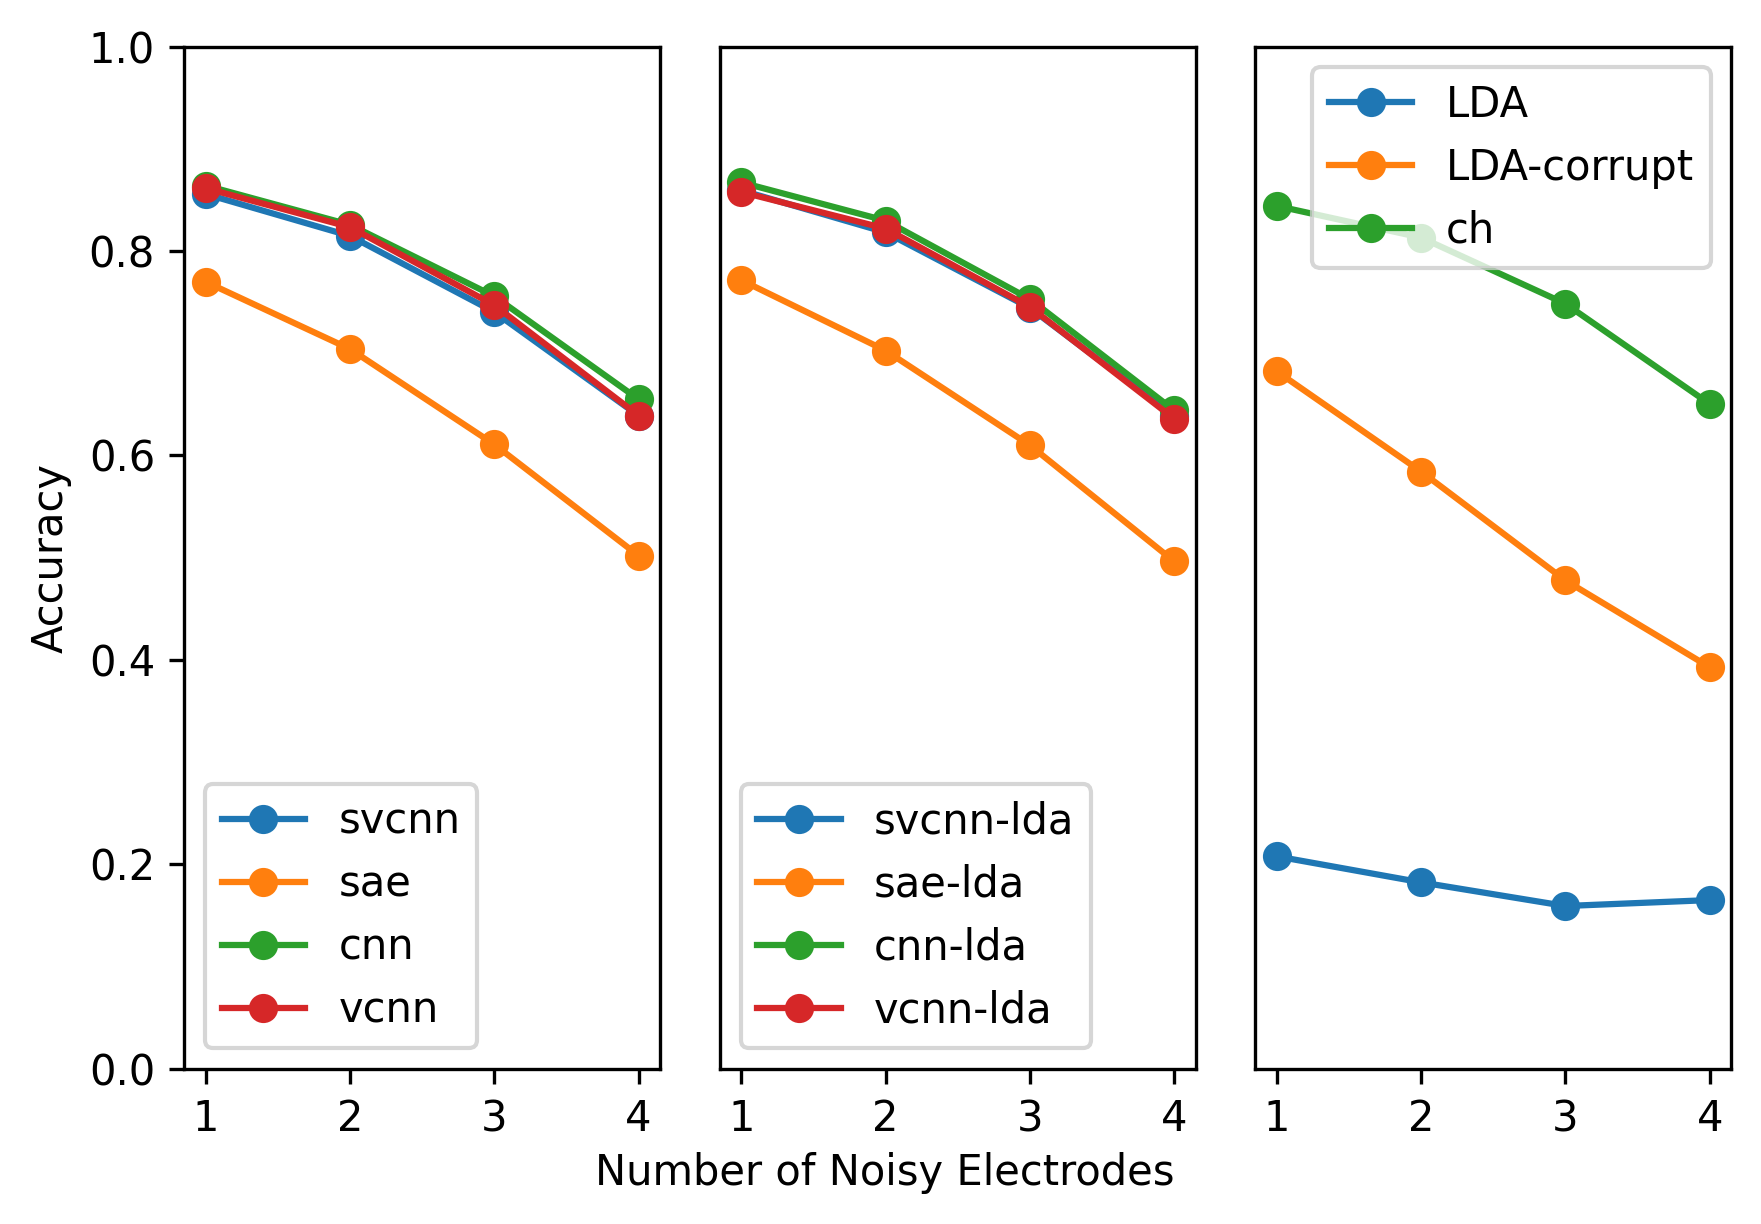

In [27]:
# Plot accuracy vs. # noisy electrodes
fig,ax = plt.subplots(1,3)
for i in range(0,4):
    ax[0].plot(gauss_noise[:,i],'-o')
for i in range(5,9):    
    ax[1].plot(gauss_noise[:,i],'-o')
for i in [10,11,14]:
    ax[2].plot(gauss_noise[:,i],'-o')    
ax[0].set_ylabel('Accuracy')
fig.text(0.5, 0, 'Number of Noisy Electrodes', ha='center')
ax[0].legend(['svcnn','sae','cnn','vcnn'])
ax[1].legend(['svcnn-lda','sae-lda','cnn-lda','vcnn-lda','rec-lda'])
ax[2].legend(['LDA','LDA-corrupt','ch'])
ax[1].set_yticks([])
ax[2].set_yticks([])
for i in range(0,3):
    ax[i].set_ylim(0,1)
    ax[i].set_xticks(range(0,4))
    ax[i].set_xticklabels(['1','2','3','4'])

fig.set_tight_layout(True)

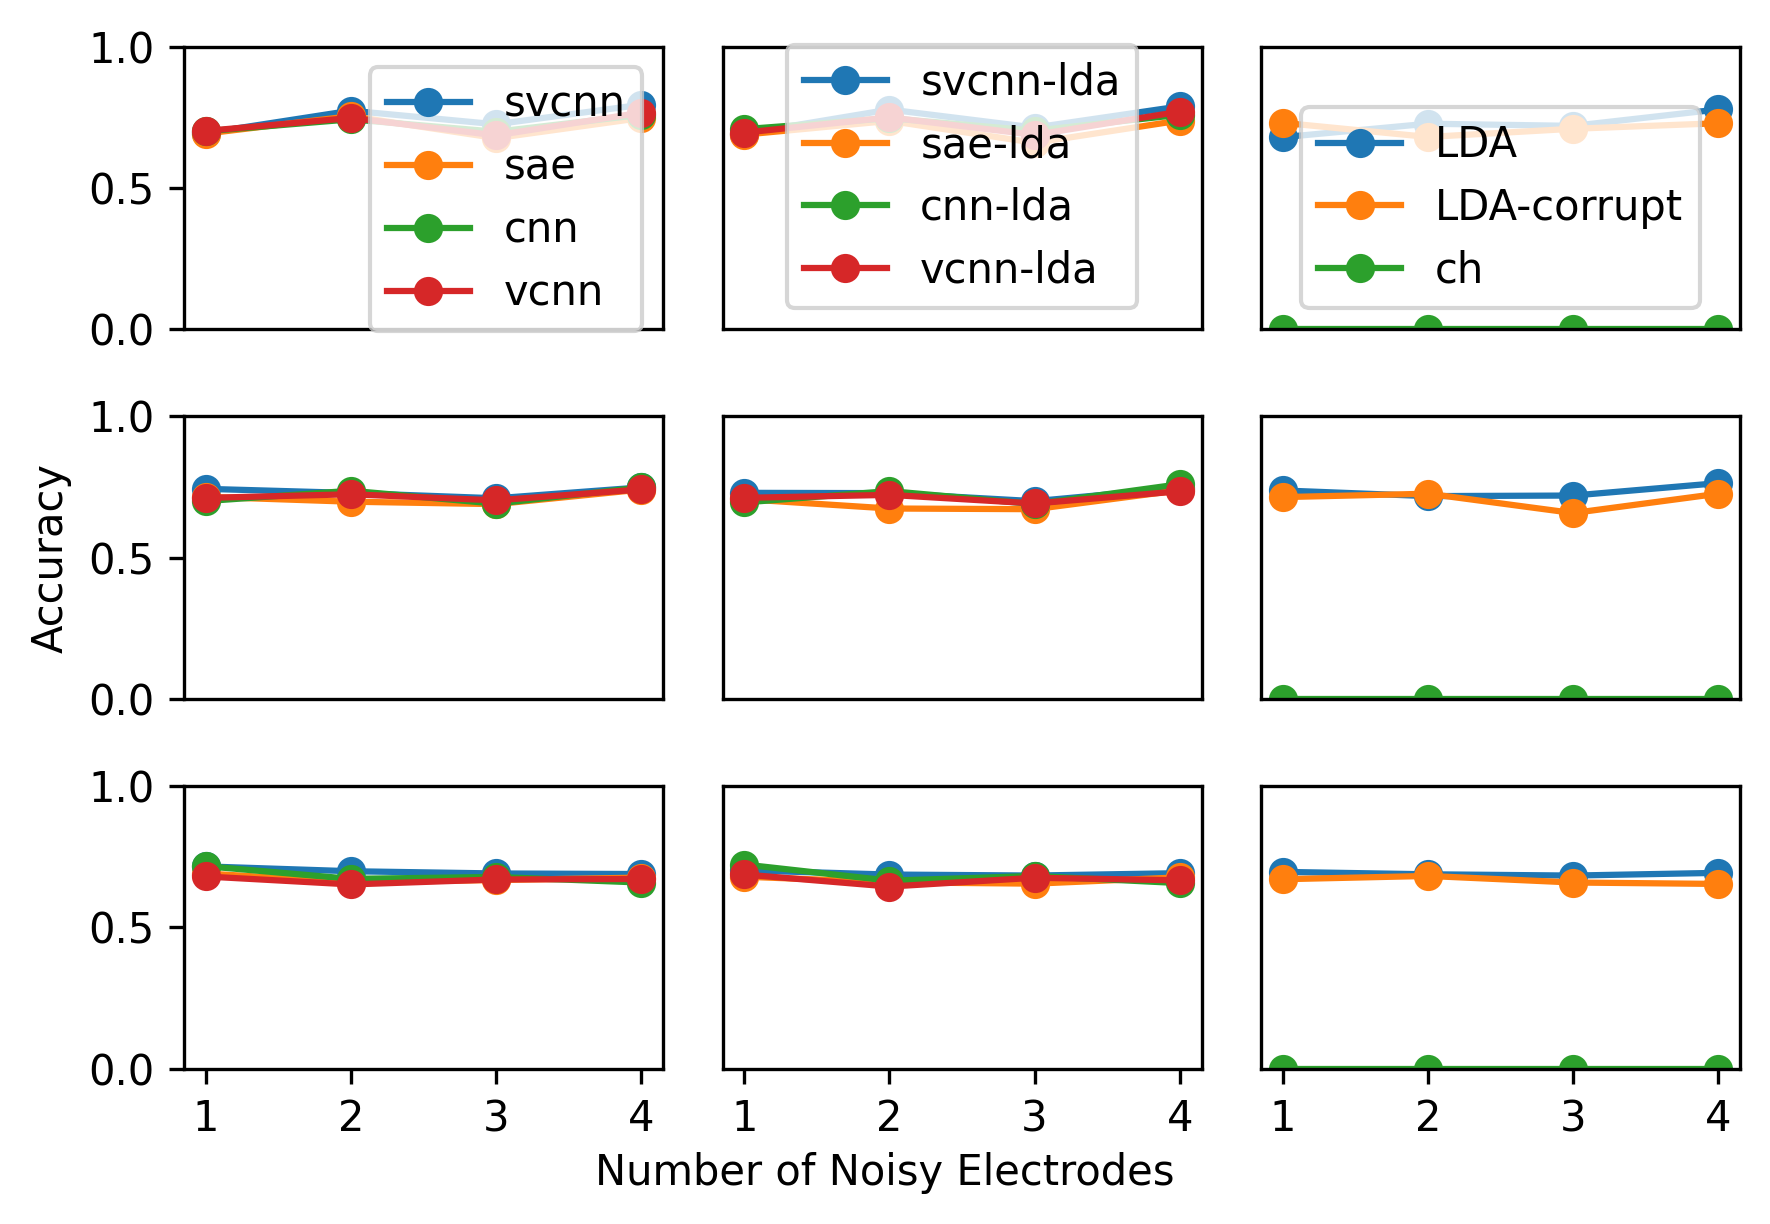

In [34]:
# Plot accuracy vs. # noisy electrodes
fig,ax = plt.subplots(3,3)
for r in range(0,3):
    for i in range(0,4):
        ax[r,0].plot(ave_noise[r,:,i],'-o')
    for i in range(5,9):    
        ax[r,1].plot(ave_noise[r,:,i],'-o')
    for i in [10,11,14]:
        ax[r,2].plot(ave_noise[r,:,i],'-o')    
    ax[r,1].set_yticks([])
    ax[r,2].set_yticks([])
    for i in range(0,3):
        ax[r,i].set_ylim(0,1)
        ax[r,i].set_xticks([])
        ax[2,i].set_xticks(range(0,4))
        ax[2,i].set_xticklabels(['1','2','3','4'])
ax[1,0].set_ylabel('Accuracy')
fig.text(0.5, 0, 'Number of Noisy Electrodes', ha='center')
ax[0,0].legend(['svcnn','sae','cnn','vcnn'])
ax[0,1].legend(['svcnn-lda','sae-lda','cnn-lda','vcnn-lda','rec-lda'])
ax[0,2].legend(['LDA','LDA-corrupt','ch'])

fig.set_tight_layout(True)

In [5]:
## Plot training metrics trajectories
# initialize parameters
train_grp = 2
dt = 'cv'
feat_type = 'feat'
latent_dim = 5
epochs = 30
n_train = 'fullgaussflat4'
train_scale = 5
foldername = 'models' + '_' + str(train_grp) + '_' + dt
batch_size = 128
n_test = 0
lr = 0.001

# initialize loss and accuracy matrices
loss = np.full([4,4,epochs],np.nan)
val_loss = np.full([4,4,epochs],np.nan)
acc = np.full([4,4,epochs],np.nan)
val_acc = np.full([4,4,epochs],np.nan)

# loop through subjects
for sub in range(1,2):#6):
    # loop through cross validations
    for cv in range(1,5):
        # load data
        filename = foldername + '/' + sub_type + str(sub) + '_' + feat_type + '_dim_' + str(latent_dim) + '_ep_' + str(epochs) + '_bat_' + str(batch_size) + '_' + n_train + '_' + str(train_scale) + '_lr_' + str(int(lr*10000)) 
        filename += '_cv_'+ str(cv) + '_sparse'
        with open(filename + '_hist.p', 'rb') as f:
            svae_hist, sae_hist, cnn_hist, vcnn_hist = pickle.load(f)

        svae_hist = np.transpose(svae_hist)

        # compile losses and accuracies (uncomment back if all models have same # epochs)
        loss[cv-1,:2,:] = np.array([svae_hist[2,:], sae_hist['loss']])#, cnn_hist['loss'], vcnn_hist['loss']])
        val_loss[cv-1,:2,:] = np.array([svae_hist[9,:], sae_hist['val_loss']])#, cnn_hist['val_loss'], vcnn_hist['val_loss']])
        acc[cv-1,:2,:] = np.array([svae_hist[5,:], sae_hist['accuracy']])#, cnn_hist['accuracy'], vcnn_hist['accuracy']])
        val_acc[cv-1,:2,:] = np.array([svae_hist[-2,:], sae_hist['val_accuracy']])#, cnn_hist['val_accuracy'], vcnn_hist['val_accuracy']])

        # 0-30 for 30 epochs
        loss[cv-1,2:,0:30] = np.array([cnn_hist['loss'], vcnn_hist['loss']])
        val_loss[cv-1,2:,0:30] = np.array([cnn_hist['val_loss'], vcnn_hist['val_loss']])
        acc[cv-1,2:,0:30] = np.array([cnn_hist['accuracy'], vcnn_hist['clf_accuracy']])
        val_acc[cv-1,2:,0:30] = np.array([cnn_hist['val_accuracy'], vcnn_hist['val_clf_accuracy']])

    # load results
    resultsfile = filename
    # with open(resultsfile + '_results.p', 'rb') as f:
    #     acc_all, acc_clean, acc_noise = pickle.load(f)

    # average metrics over cvs
    ave_loss = np.mean(loss,axis=0)
    ave_val_loss = np.mean(val_loss,axis=0)
    ave_acc = np.mean(acc,axis=0)
    ave_val_acc = np.mean(val_acc,axis=0)

    # plot metrics over epochs
    plt.figure(sub)
    for i in range(0,4):
        ax = plt.subplot(2,2,i+1)
        ax.plot(ave_loss[i])
        ax.plot(ave_val_loss[i])
        # ax.set_ylim(0,5)
    plt.figure(sub+1)
    for i in range(0,4):
        ax2 = plt.subplot(2,2,i+1)
        ax2.plot(ave_acc[i])
        ax2.plot(ave_val_acc[i])
        ax2.set_ylim(0,1)

KeyError: 'clf_accuracy'

In [7]:
# Load noise results
sub_all, sub_noise, sub_clean, ave_all, ave_noise, ave_clean = loop.ave_results(params, sub_type, train_grp=2, feat_type='feat',epochs=30,n_train='fullgaussflat4',train_scale=5,n_test='partgauss2', latent_dim=4,loop_i='noise', dt='cv')
sub_all, sub_noise, sub_clean, flat_ave_all, flat_ave_noise, flat_ave_clean = loop.ave_results(params, sub_type, train_grp=2, feat_type='feat',epochs=30,n_train='fullgaussflat4',train_scale=5,n_test='partflat2', latent_dim=4,loop_i='noise',dt='cv')

NameError: name 'flat_ave_noise' is not defined

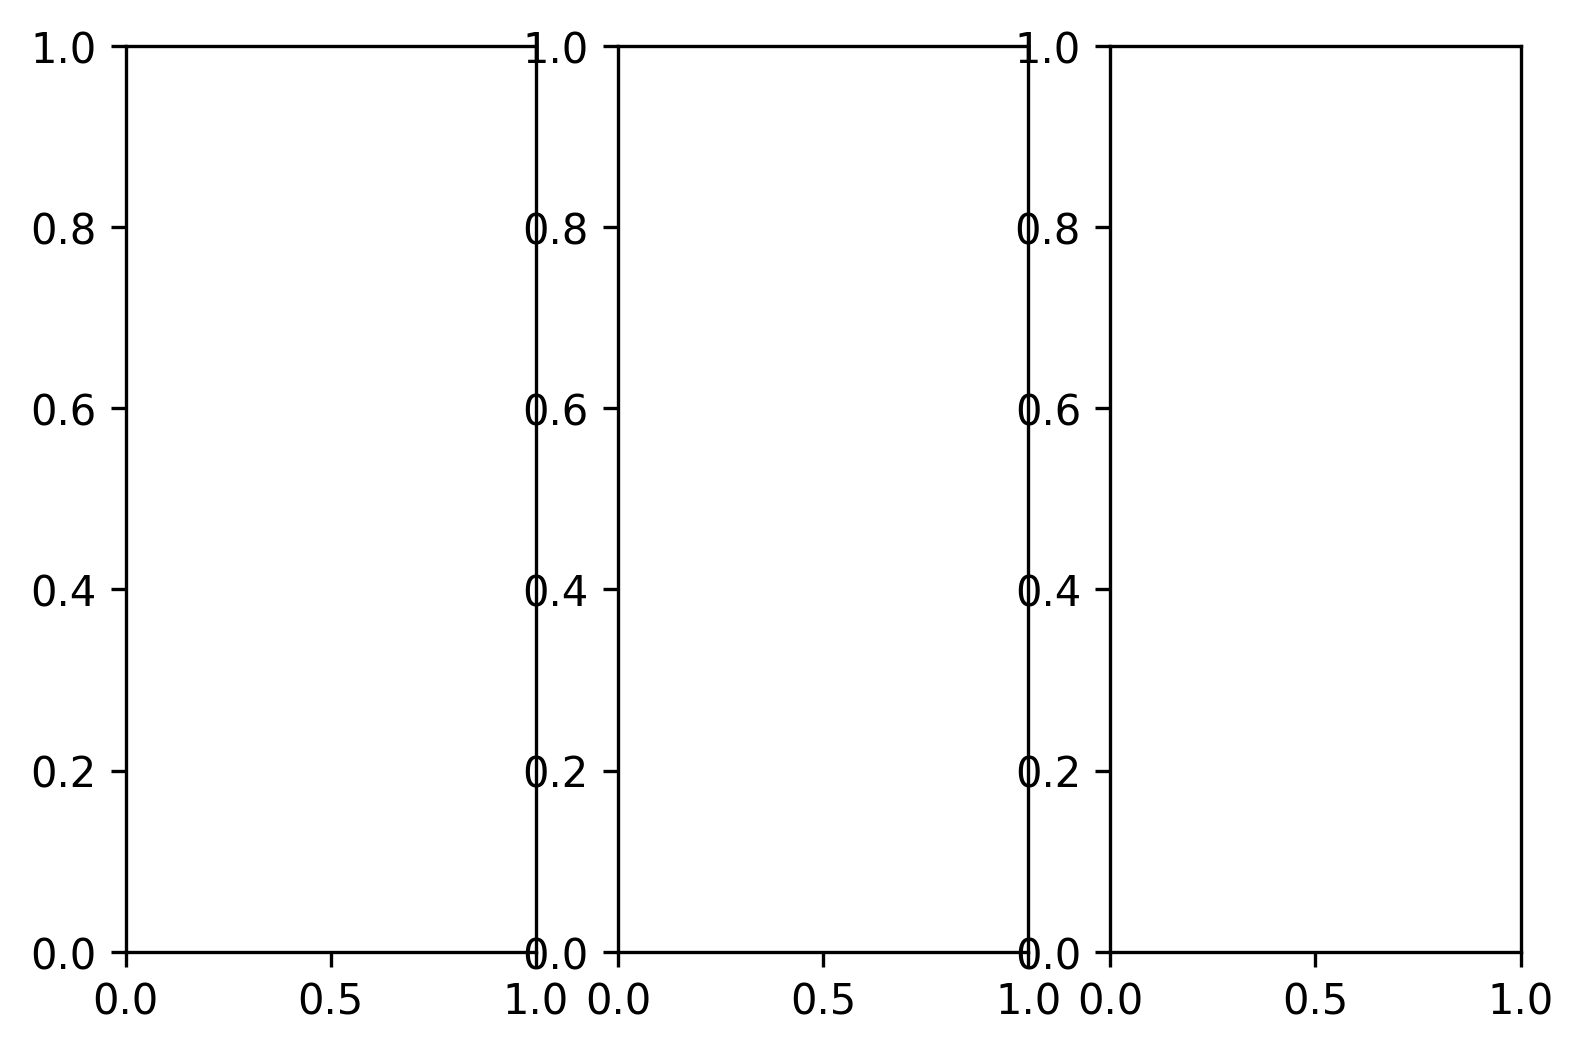

In [7]:
# Plot accuracy vs. noise
fig,ax = plt.subplots(1,3)
for i in range(0,4):
    ax[0].plot(np.hstack((flat_ave_noise[:,i],ave_noise[:,i])),'-o')
for i in range(4,9):    
    ax[1].plot(np.hstack((flat_ave_noise[:,i],ave_noise[:,i])),'-o')
for i in range(9,14):    
    ax[2].plot(np.hstack((flat_ave_noise[:,i],ave_noise[:,i])),'--o')
ax[0].set_ylabel('Accuracy')
fig.text(0.5, 0, 'Type of Noise', ha='center')
ax[0].legend(['svcnn','sae','cnn','vcnn'])
ax[1].legend(['svcnn-lda','sae-lda','cnn-lda','vcnn-lda','rec-lda'])
ax[2].legend(['LDA','LDA-corrupt','QDA','QDA-corrupt','ch'])
ax[1].set_yticks([])
ax[2].set_yticks([])
for i in range(0,3):
    ax[i].set_ylim(0,1)
    ax[i].set_xticks(range(0,6))
    ax[i].set_xticklabels(['Flat','1','2','3','4','5'])

fig.set_tight_layout(True)

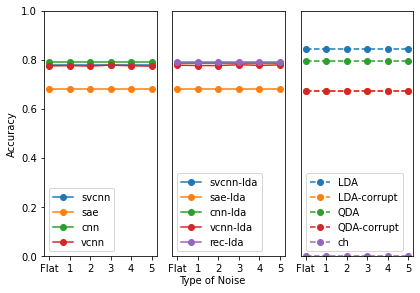

In [10]:
# Plot accuracy vs. noise
fig,ax = plt.subplots(1,3)
for i in range(0,4):
    ax[0].plot(np.hstack((flat_ave_clean[:,i],ave_clean[:,i])),'-o')
for i in range(4,9):    
    ax[1].plot(np.hstack((flat_ave_clean[:,i],ave_clean[:,i])),'-o')
for i in range(9,14):    
    ax[2].plot(np.hstack((flat_ave_clean[:,i],ave_clean[:,i])),'--o')
ax[0].set_ylabel('Accuracy')
fig.text(0.5, 0, 'Type of Noise', ha='center')
ax[0].legend(['svcnn','sae','cnn','vcnn'])
ax[1].legend(['svcnn-lda','sae-lda','cnn-lda','vcnn-lda','rec-lda'])
ax[2].legend(['LDA','LDA-corrupt','QDA','QDA-corrupt','ch'])
ax[1].set_yticks([])
ax[2].set_yticks([])
for i in range(0,3):
    ax[i].set_ylim(0,1)
    ax[i].set_xticks(range(0,6))
    ax[i].set_xticklabels(['Flat','1','2','3','4','5'])

fig.set_tight_layout(True)

In [3]:
# Loop through noise
acc_all, acc_noise, acc_clean, file_name = loop.loop_noise(raw, params, sub_type, load=False, n_train='fullgaussflat4', train_scale=5, n_test=0,epochs=30, batch_size = 128, sparsity=True,dt='cv',feat_type='feat',noise=True, latent_dim=4)

10 - clf_loss: 0.7969 - decoder_accuracy: 0.0039 - clf_accuracy: 0.6803 - val_loss: 1.0422 - val_decoder_loss: 0.0800 - val_clf_loss: 0.9572 - val_decoder_accuracy: 0.0020 - val_clf_accuracy: 0.6190
Epoch 11/30
18900/18900 [==============================] - 2s 126us/sample - loss: 0.8524 - decoder_loss: 0.0848 - clf_loss: 0.7650 - decoder_accuracy: 0.0039 - clf_accuracy: 0.6941 - val_loss: 1.0159 - val_decoder_loss: 0.0789 - val_clf_loss: 0.9367 - val_decoder_accuracy: 0.0020 - val_clf_accuracy: 0.6186
Epoch 12/30
18900/18900 [==============================] - 2s 115us/sample - loss: 0.8229 - decoder_loss: 0.0882 - clf_loss: 0.7323 - decoder_accuracy: 0.0039 - clf_accuracy: 0.7081 - val_loss: 0.9926 - val_decoder_loss: 0.0857 - val_clf_loss: 0.9000 - val_decoder_accuracy: 0.0020 - val_clf_accuracy: 0.6271
Epoch 13/30
18900/18900 [==============================] - 2s 114us/sample - loss: 0.8014 - decoder_loss: 0.0913 - clf_loss: 0.7074 - decoder_accuracy: 0.0039 - clf_accuracy: 0.7258 -

## Latent Dimension Loop

In [ ]:
# loop through latent dimensions
sub_all, sub_noise, sub_clean, file_name = loop.loop_alldim(raw, params, sub_type, load=False, n_train='gaussflat', train_scale=3, n_test='gauss', test_scale=1,epochs=30, sparsity=True, dt='0414')

In [ ]:
# load results from latent dimension loop, sparse vs. not sparse
sub_all, sub_noise, sub_clean, sparse_all, sparse_noise, sparse_clean = loop.load_results(params, sub_type=sub_type,sparsity=True, dt='0414')
sub_all, sub_noise, sub_clean, ave_all, ave_noise, ave_clean = loop.load_results(params, sub_type=sub_type,sparsity=False, dt='0414')

In [ ]:
# Plot accuracy vs. latent dimension
fig,ax = plt.subplots(1,2)
for i in range(0,4):
    ax[0].plot(ave_noise[:,i],'-o')
    ax[1].plot(sparse_noise[:,i],'-o')
ax[0].set_ylabel('Accuracy')
fig.text(0.5, 0.04, 'Latent Dimension', ha='center')
ax[0].set_ylim(0.5,1)
ax[1].set_ylim(0.5,1)
ax[0].legend(['svcnn','sae','cnn','vcnn'])